In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


### 1. Gender-wise population growth rate of India
In India there were (are) various socio-cultural taboos associated with girl-children birth, specially in rural areas. Hence, based on the country wise data of an international census bureau (found in bigquery public dataset, accessed through Kaggle) we investigate if that has any imprint in the female population growth rate of India.  The following code also fills the gap in the data-set not enlisting year to year genderwise population growth rate of a country. We also compare the female growth rate of India with global average.

In [3]:
# The SQL code accesses two tables in the dataset:
# "midyear_population_agespecific" table: Used columns- country_code, sex, year, population (for midyear population)
# "birth_death_growth_rates" table: We use columns- country_code, year, growth_rate

# A combination of many SQL concepts are used: Aggregate (window) functions including conditional aggregation, Joining tables, 
# CTE, GROUP BY, ORDER BY and so on.

query4 = """WITH country_yearwise_tot_pop AS
            (SELECT country_code, sex, year, SUM(population) AS tot_population
            from `bigquery-public-data.census_bureau_international.midyear_population_agespecific`
            GROUP BY sex,year,country_code
            ),
            yearwise_pop AS
            (SELECT sex,year,SUM(tot_population) AS glob_pop,
            SUM(CASE WHEN country_code ='IN' THEN tot_population ELSE 0 END) AS ind_pop
            from country_yearwise_tot_pop
            GROUP BY sex, year
            )
            SELECT y.year, y.ind_pop as IND_total_female_population,
            (y.glob_pop-lag(y.glob_pop)
                OVER(PARTITION BY y.sex
                    ORDER BY y.year))*100/(lag(y.glob_pop)
                    OVER(PARTITION BY y.sex
                    ORDER BY y.year)) AS glob_female_pop_growth_rate,
            (y.ind_pop-lag(y.ind_pop)
                OVER(PARTITION BY y.sex
                    ORDER BY y.year))*100/(lag(y.ind_pop)
                    OVER(PARTITION BY y.sex
                    ORDER BY y.year)) AS IND_female_pop_growth_rate, bg.growth_rate AS IND_tot_pop_growth_rate
            from yearwise_pop AS y
            INNER JOIN `bigquery-public-data.census_bureau_international.birth_death_growth_rates` AS bg
                ON y.year=bg.year
            WHERE bg.country_code='IN' AND y.sex='Female'
            ORDER BY IND_female_pop_growth_rate DESC
            """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**4)
query_job = client.query(query4, job_config=safe_config)
result4 = query_job.result().to_dataframe()

In [4]:
### First few lines of the output table

result4.iloc[0:10,:]

,year,IND_total_female_population,glob_female_pop_growth_rate,IND_female_pop_growth_rate,IND_tot_pop_growth_rate
0,1992,420809064,2.559526,1.876998,1.899
1,1993,428678463,2.222168,1.870064,1.888
2,1994,436644861,1.961940,1.858362,1.874
3,1995,444691383,1.840646,1.842807,1.856
4,1996,452801917,2.715520,1.823857,1.834
5,1997,460941789,1.394546,1.797667,1.801
6,1998,469076391,1.307810,1.764779,1.766
7,1999,477189444,1.286245,1.729580,1.729
8,2000,485263636,1.265865,1.692031,1.689
9,2001,493315013,1.247211,1.659176,1.661


Text(0, 0.5, ' ')

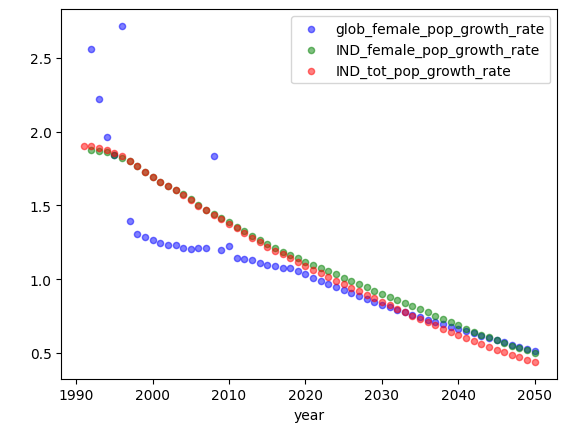

In [5]:
ax1 = result4.plot(kind='scatter',x="year", y="glob_female_pop_growth_rate",color='b',label='glob_female_pop_growth_rate',alpha=0.5)  
ax2 = result4.plot(kind='scatter', x="year", y="IND_female_pop_growth_rate",color='g',label='IND_female_pop_growth_rate',alpha=0.5, ax=ax1)
ax3 = result4.plot(kind='scatter', x="year", y="IND_tot_pop_growth_rate",color='r',label='IND_tot_pop_growth_rate',alpha=0.5, ax=ax1)

ax1.set_ylabel(' ')